In [2]:
import bt

In [3]:
%matplotlib inline

In [4]:
# download data
data = bt.get('aapl,msft,c,gs,ge', start='2010-01-01')

# calculate moving average DataFrame using pandas' rolling_mean
import pandas as pd
# a rolling mean is a moving average, right?
sma = data.rolling(50).mean()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


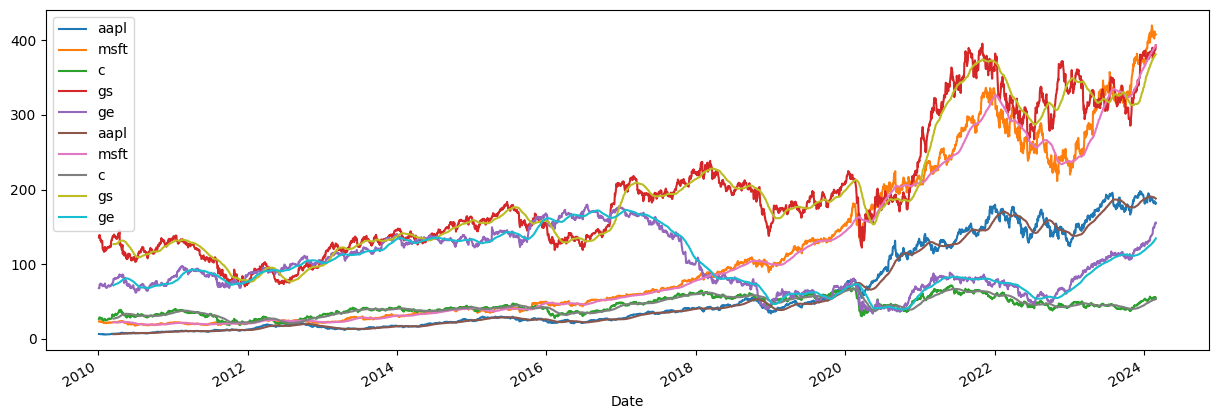

In [5]:
# let's see what the data looks like - this is by no means a pretty chart, but it does the job
plot = bt.merge(data, sma).plot(figsize=(15, 5))

In [28]:
class SelectWhere(bt.Algo):

    """
    Selects securities based on an indicator DataFrame.

    Selects securities where the value is True on the current date (target.now).

    Args:
        * signal (DataFrame): DataFrame containing the signal (boolean DataFrame)

    Sets:
        * selected

    """
    def __init__(self, signal):
        self.signal = signal

    def __call__(self, target):
        # get signal on target.now
        if target.now in self.signal.index:
            sig = self.signal.loc[target.now]

            # get indices where true as list
            selected = list(sig.index[sig])

            # save in temp - this will be used by the weighing algo
            target.temp['selected'] = selected
        # return True because we want to keep on moving down the stack
        return True

In [29]:
signal = data > sma

In [30]:
data

,aapl,msft,c,gs,ge
Date,,,,,
2010-01-04,6.470741,23.431595,26.639050,135.576187,67.992638
2010-01-05,6.481930,23.439163,27.657598,137.973099,68.344696
2010-01-06,6.378824,23.295319,28.519451,136.500458,67.992638
2010-01-07,6.367032,23.053045,28.597797,139.171539,71.513283
2010-01-08,6.409364,23.212032,28.127701,136.539612,73.053596
...,...,...,...,...,...
2024-02-22,184.369995,411.649994,55.900002,387.722382,151.669998
2024-02-23,182.520004,410.339996,55.930000,388.298279,153.330002
2024-02-26,181.160004,407.540009,55.360001,387.474152,154.770004


In [31]:
sma

,aapl,msft,c,gs,ge
Date,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2024-02-22,188.981607,390.029260,52.527804,378.746196,131.907299
2024-02-23,188.773331,390.823767,52.692508,379.526466,132.569809
2024-02-26,188.507294,391.500788,52.847596,380.273373,133.220344


In [32]:
signal

,aapl,msft,c,gs,ge
Date,,,,,
2010-01-04,False,False,False,False,False
2010-01-05,False,False,False,False,False
2010-01-06,False,False,False,False,False
2010-01-07,False,False,False,False,False
2010-01-08,False,False,False,False,False
...,...,...,...,...,...
2024-02-22,False,True,True,True,True
2024-02-23,False,True,True,True,True
2024-02-26,False,True,True,True,True


In [33]:
# first we create the Strategy
s = bt.Strategy('above50sma', [SelectWhere(signal),
                               bt.algos.WeighEqually(),
                               bt.algos.Rebalance()])

In [34]:
# now we create the Backtest
t = bt.Backtest(s, data)

In [35]:
# and let's run it!
res = bt.run(t)

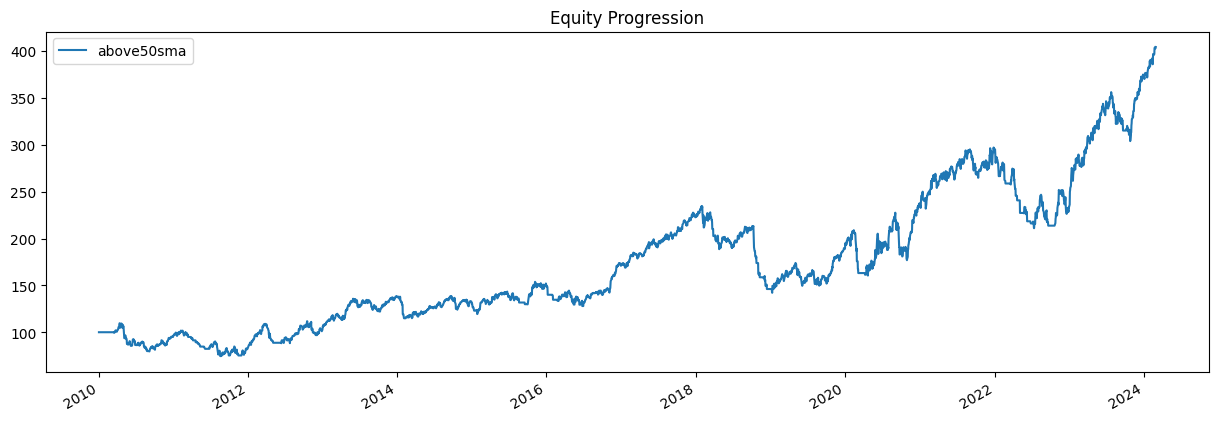

In [36]:
# what does the equity curve look like?
res.plot();

In [37]:
# and some performance stats
res.display()

Stat                 above50sma
-------------------  ------------
Start                2010-01-03
End                  2024-02-28
Risk-free rate       0.00%

Total Return         304.36%
Daily Sharpe         0.61
Daily Sortino        0.94
CAGR                 10.38%
Max Drawdown         -39.43%
Calmar Ratio         0.26

MTD                  5.43%
3m                   15.92%
6m                   22.18%
YTD                  8.10%
1Y                   45.72%
3Y (ann.)            15.42%
5Y (ann.)            20.42%
10Y (ann.)           13.08%
Since Incep. (ann.)  10.38%

Daily Sharpe         0.61
Daily Sortino        0.94
Daily Mean (ann.)    11.77%
Daily Vol (ann.)     19.35%
Daily Skew           -0.57
Daily Kurt           4.55
Best Day             5.82%
Worst Day            -8.26%

Monthly Sharpe       0.56
Monthly Sortino      0.97
Monthly Mean (ann.)  12.44%
Monthly Vol (ann.)   22.27%
Monthly Skew         -0.25
Monthly Kurt         0.65
Best Month           21.65%
Worst Month         

In [38]:
def above_sma(tickers, sma_per=50, start='2010-01-01', name='above_sma'):
    """
    Long securities that are above their n period
    Simple Moving Averages with equal weights.
    """
    # download data
    data = bt.get(tickers, start=start)
    # calc sma
    sma = data.rolling(sma_per).mean()

    # create strategy
    s = bt.Strategy(name, [SelectWhere(data > sma),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])

    # now we create the backtest
    return bt.Backtest(s, data)

In [39]:
# simple backtest to test long-only allocation
def long_only_ew(tickers, start='2010-01-01', name='long_only_ew'):
    s = bt.Strategy(name, [bt.algos.RunOnce(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])
    data = bt.get(tickers, start=start)
    return bt.Backtest(s, data)

# create the backtests
tickers = 'aapl,msft,c,gs,ge'
sma10 = above_sma(tickers, sma_per=10, name='sma10')
sma20 = above_sma(tickers, sma_per=20, name='sma20')
sma40 = above_sma(tickers, sma_per=40, name='sma40')
benchmark = long_only_ew('spy', name='spy')

# run all the backtests!
res2 = bt.run(sma10, sma20, sma40, benchmark)

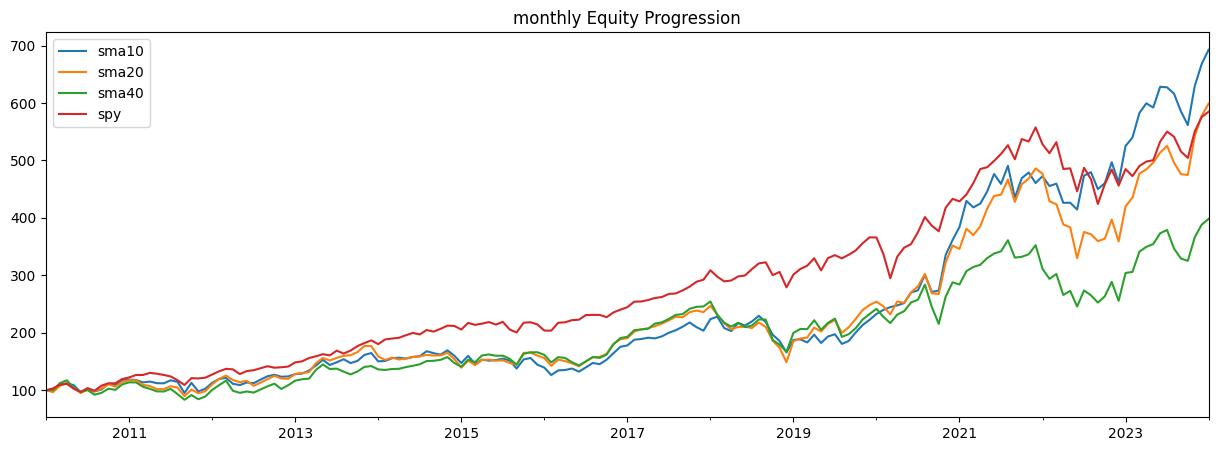

In [43]:
res2.plot(freq='m');

In [41]:
res2.display()

Stat                 sma10       sma20       sma40       spy
-------------------  ----------  ----------  ----------  ----------
Start                2010-01-03  2010-01-03  2010-01-03  2010-01-03
End                  2024-02-28  2024-02-28  2024-02-28  2024-02-28
Risk-free rate       0.00%       0.00%       0.00%       0.00%

Total Return         589.99%     531.99%     321.25%     481.04%
Daily Sharpe         0.78        0.76        0.63        0.81
Daily Sortino        1.24        1.20        0.99        1.25
CAGR                 14.62%      13.91%      10.70%      13.24%
Max Drawdown         -31.77%     -40.72%     -34.93%     -33.72%
Calmar Ratio         0.46        0.34        0.31        0.39

MTD                  6.85%       5.53%       5.78%       4.84%
3m                   17.07%      17.86%      16.38%      11.73%
6m                   22.04%      29.86%      22.01%      15.21%
YTD                  10.82%      9.38%       8.53%       6.51%
1Y                   37.09%      45.

# SMA Crossover Strategy

In [44]:
class WeighTarget(bt.Algo):
    """
    Sets target weights based on a target weight DataFrame.

    Args:
        * target_weights (DataFrame): DataFrame containing the target weights

    Sets:
        * weights

    """

    def __init__(self, target_weights):
        self.tw = target_weights

    def __call__(self, target):
        # get target weights on date target.now
        if target.now in self.tw.index:
            w = self.tw.loc[target.now]

            # save in temp - this will be used by the weighing algo
            # also dropping any na's just in case they pop up
            target.temp['weights'] = w.dropna()

        # return True because we want to keep on moving down the stack
        return True

In [45]:
## download some data & calc SMAs
data = bt.get('spy', start='2010-01-01')
sma50 = data.rolling(50).mean()
sma200 = data.rolling(200).mean()

In [46]:
data

,spy
Date,
2010-01-04,87.129944
2010-01-05,87.360580
2010-01-06,87.422081
2010-01-07,87.791100
2010-01-08,88.083267
...,...
2024-02-22,507.500000
2024-02-23,507.850006
2024-02-26,505.989990


In [47]:
sma50

,spy
Date,
2010-01-04,NaN
2010-01-05,NaN
2010-01-06,NaN
2010-01-07,NaN
2010-01-08,NaN
...,...
2024-02-22,482.306292
2024-02-23,483.260803
2024-02-26,484.136084


In [49]:
sma200

,spy
Date,
2010-01-04,NaN
2010-01-05,NaN
2010-01-06,NaN
2010-01-07,NaN
2010-01-08,NaN
...,...
2024-02-22,446.553867
2024-02-23,447.052555
2024-02-26,447.550891


In [51]:
## now we need to calculate our target weight DataFrame
# first we will copy the sma200 DataFrame since our weights will have the same strucutre
tw = sma200.copy()
# set appropriate target weights
tw[sma50 > sma200] = 1.0
tw[sma50 <= sma200] = -1.0

In [56]:
tw

,spy
Date,
2010-01-04,NaN
2010-01-05,NaN
2010-01-06,NaN
2010-01-07,NaN
2010-01-08,NaN
...,...
2024-02-22,1.0
2024-02-23,1.0
2024-02-26,1.0


In [55]:
tw['spy'].unique()

array([nan,  1., -1.])

In [57]:
# here we will set the weight to 0 - this is because the sma200 needs 200 data points before
# calculating its first point. Therefore, it will start with a bunch of nulls (NaNs).
tw[sma200.isnull()] = 0.0

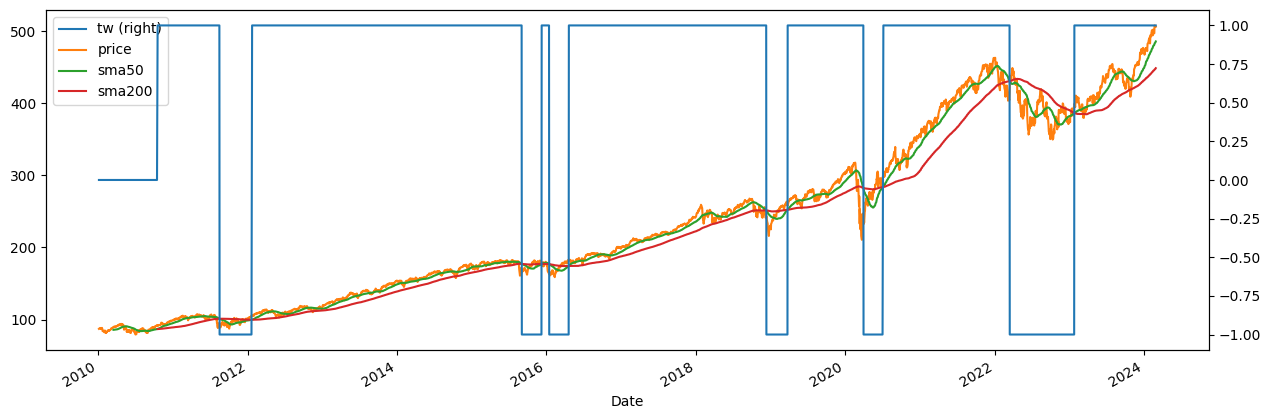

In [58]:
# plot the target weights + chart of price & SMAs
tmp = bt.merge(tw, data, sma50, sma200)
tmp.columns = ['tw', 'price', 'sma50', 'sma200']
ax = tmp.plot(figsize=(15,5), secondary_y=['tw'])

In [59]:
ma_cross = bt.Strategy('ma_cross', [WeighTarget(tw),
                                    bt.algos.Rebalance()])

t = bt.Backtest(ma_cross, data)
res = bt.run(t)

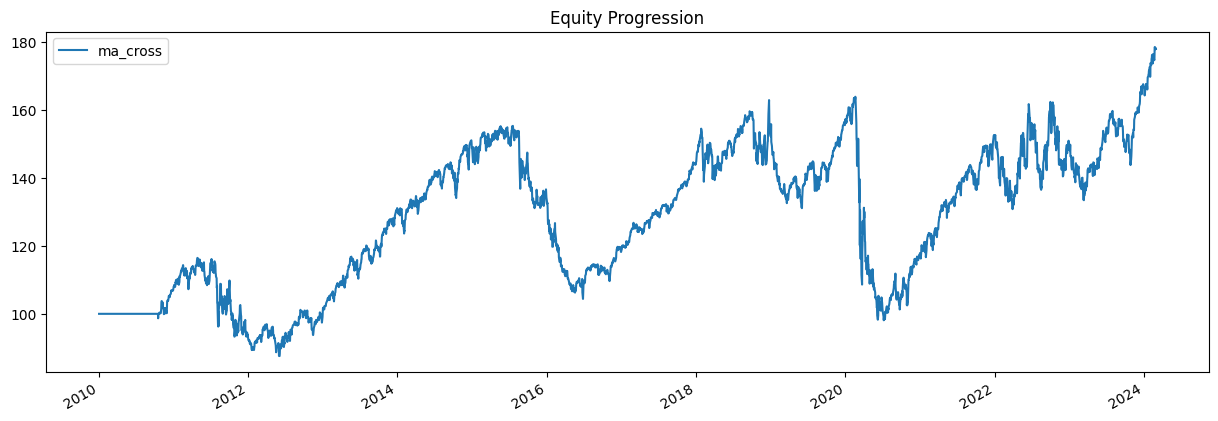

In [60]:
res.plot();

# Exploring the Tree Structure

In [61]:
# first let's create a helper function to create a ma cross backtest
def ma_cross(ticker, start='2010-01-01',
             short_ma=50, long_ma=200, name='ma_cross'):
    # these are all the same steps as above
    data = bt.get(ticker, start=start)
    short_sma = data.rolling(short_ma).mean()
    long_sma  = data.rolling(long_ma).mean()

    # target weights
    tw = long_sma.copy()
    tw[short_sma > long_sma] = 1.0
    tw[short_sma <= long_sma] = -1.0
    tw[long_sma.isnull()] = 0.0

    # here we specify the children (3rd) arguemnt to make sure the strategy
    # has the proper universe. This is necessary in strategies of strategies
    s = bt.Strategy(name, [WeighTarget(tw), bt.algos.Rebalance()], [ticker])

    return bt.Backtest(s, data)

In [62]:
# ok now let's create a few backtests and gather the results.
# these will later become our "synthetic securities"
t1 = ma_cross('aapl', name='aapl_ma_cross')
t2 = ma_cross('msft', name='msft_ma_cross')

In [63]:
# let's run these strategies now
res = bt.run(t1, t2)

In [66]:
# now that we have run the strategies, let's extract
# the data to create "synthetic securities"
data = bt.merge(res['aapl_ma_cross'].prices, res['msft_ma_cross'].prices)

In [67]:
data

,aapl_ma_cross,msft_ma_cross
2010-01-03,100.000000,100.000000
2010-01-04,100.000000,100.000000
2010-01-05,100.000000,100.000000
2010-01-06,100.000000,100.000000
2010-01-07,100.000000,100.000000
...,...,...
2024-02-22,676.136176,641.404973
2024-02-23,669.351889,639.363866
2024-02-26,664.364495,635.001205
2024-02-27,669.755284,634.907723


In [68]:
# now we have our new data. This data is basically the equity
# curves of both backtested strategies. Now we can just use this
# to test any old strategy, just like before.
s = bt.Strategy('s', [bt.algos.SelectAll(),
                      bt.algos.WeighInvVol(),
                      bt.algos.Rebalance()])

# create and run
t = bt.Backtest(s, data)
res = bt.run(t)

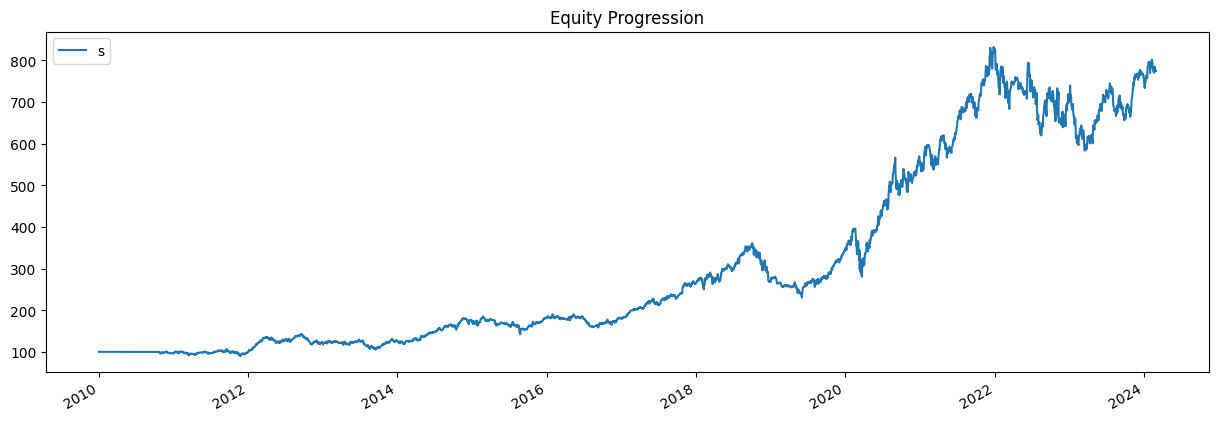

In [69]:
res.plot();

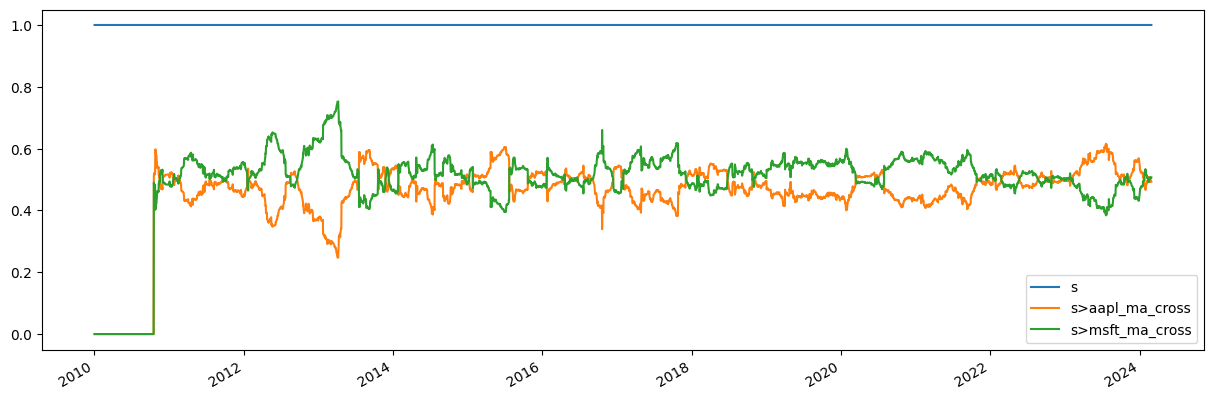

In [71]:
res.plot_weights();

In [72]:
# once again, we will create a few backtests
# these will be the child strategies
t1 = ma_cross('aapl', name='aapl_ma_cross')
t2 = ma_cross('msft', name='msft_ma_cross')

# let's extract the data object
data = bt.merge(t1.data, t2.data)

# now we create the parent strategy
# we specify the children to be the two
# strategies created above
s = bt.Strategy('s', [bt.algos.SelectAll(),
                      bt.algos.WeighInvVol(),
                      bt.algos.Rebalance()],
                [t1.strategy, t2.strategy])

# create and run
t = bt.Backtest(s, data)
res = bt.run(t)

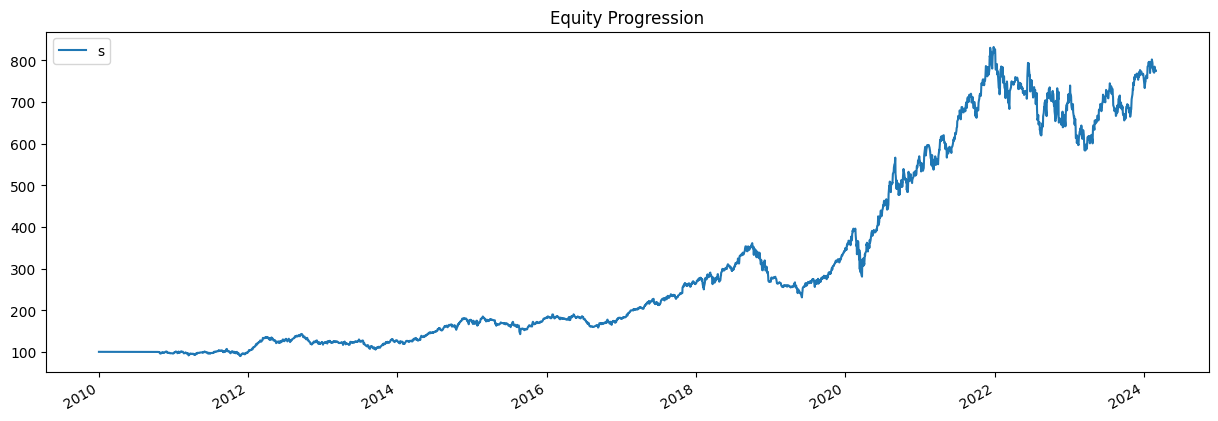

In [73]:
res.plot();

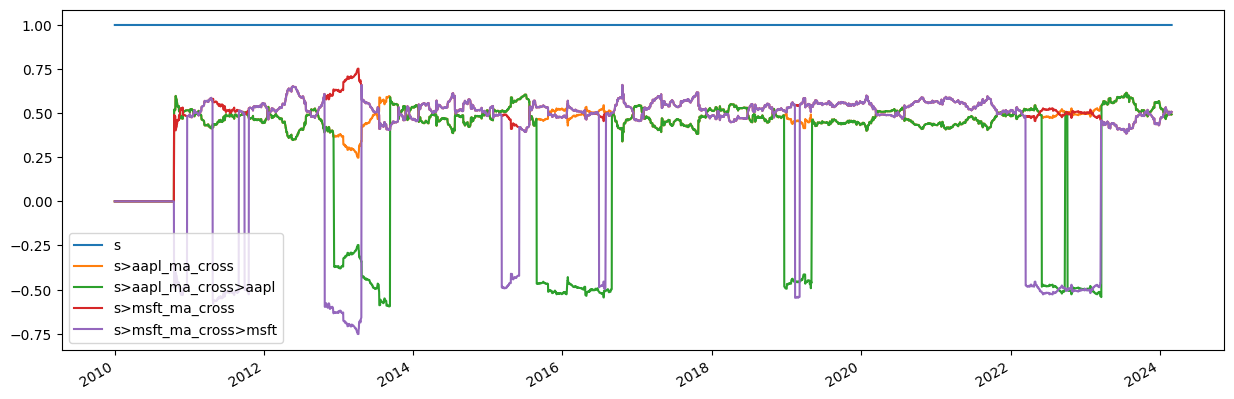

In [74]:
res.plot_weights();